In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [79]:
# Загружаем основные данные
train_df = pd.read_csv("data/train.csv")
train_df["dt"] = pd.to_datetime(train_df["dt"], format="%d.%m.%Y")

In [80]:
# Загружаем дополнительные данные
data_files = {
    "lme": "data/Индекс LME.xlsx",
    "fuel": "data/xlsx/Топливо.xlsx",
    "macro": "data/xlsx/Макропоказатели.xlsx"
}

dfs = {key: pd.read_excel(path) for key, path in data_files.items()}
for df in dfs.values():
    df["dt"] = pd.to_datetime(df["dt"], format="%d.%m.%Y")

In [81]:
# Объединяем данные
merged_df = train_df.copy()
for key, df in dfs.items():
    merged_df = merged_df.merge(df, on="dt", how="left")


In [82]:
# Заполняем пропуски
numeric_cols = merged_df.select_dtypes(include=["number"]).columns
merged_df[numeric_cols] = merged_df[numeric_cols].interpolate(method="linear").fillna(method="ffill")

C:\Users\sunbeam\AppData\Local\Temp\ipykernel_19560\3054271365.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[numeric_cols] = merged_df[numeric_cols].interpolate(method="linear").fillna(method="ffill")


In [83]:
lags = [1, 2, 4, 8, 12]
for lag in lags:
    merged_df[f"lag_{lag}"] = merged_df["Цена на арматуру"].shift(lag)

merged_df["sma_4"] = merged_df["Цена на арматуру"].rolling(window=4).mean()
merged_df["sma_8"] = merged_df["Цена на арматуру"].rolling(window=8).mean()
merged_df.fillna(0, inplace=True)

C:\Users\sunbeam\AppData\Local\Temp\ipykernel_19560\4173614084.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.fillna(0, inplace=True)


In [84]:
# Разделяем выборки
X = merged_df.drop(columns=["Цена на арматуру", "dt"])
y = merged_df["Цена на арматуру"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [85]:
# Масштабируем признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [86]:
# Обучаем улучшенную модель
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.03, max_depth=5, min_samples_split=3, random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=5, min_samples_split=3,
                          n_estimators=1000, random_state=42)

In [87]:
# Прогнозируем и оцениваем качество
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")

Средняя абсолютная ошибка (MAE): 9003.88


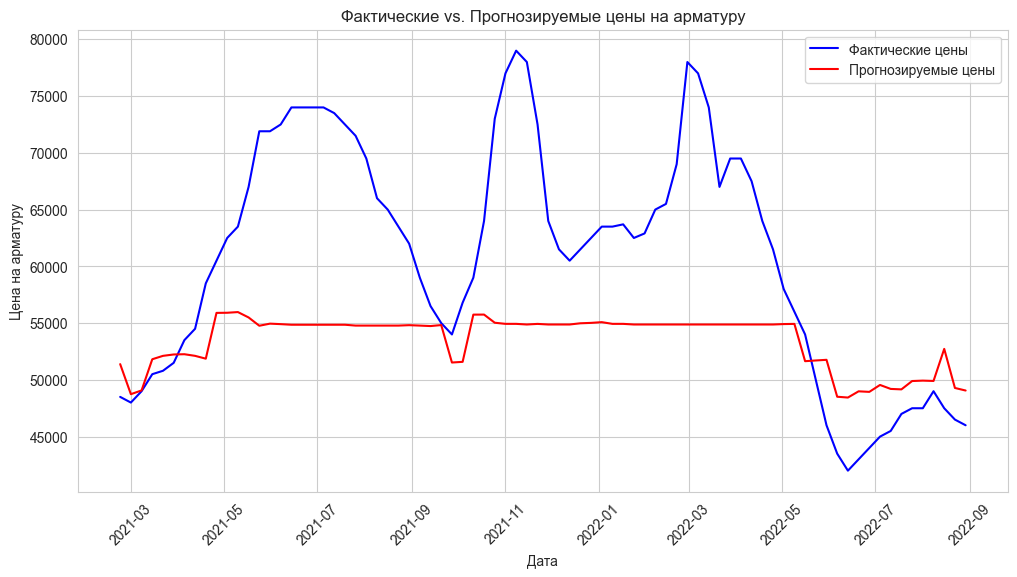

In [91]:
# Визуализация фактических и предсказанных цен
plt.figure(figsize=(12, 6))
plt.plot(merged_df["dt"].iloc[-len(y_test):], y_test, label="Фактические цены", color='blue')
plt.plot(merged_df["dt"].iloc[-len(y_test):], y_pred, label="Прогнозируемые цены", color='red')
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Фактические vs. Прогнозируемые цены на арматуру")
plt.xticks(rotation=45)
plt.show()